In [1]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [2]:
from qiskit import *

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_london')
backend_prop = backend.properties()
noise_model = NoiseModel.from_backend(backend)


# Setting up Readout Errors 
Error rates as per the London Noise Model

In [3]:
noise_model


NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['id', 'measure', 'cx', 'u2', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]

In [5]:
backend.properties().qubits


[[Nduv('2020-08-13T07:10:16Z', T1, µs, 70.18952603292055),
  Nduv('2020-08-13T07:11:16Z', T2, µs, 107.58475662976616),
  Nduv('2020-08-13T07:29:38Z', frequency, GHz, 5.254007813204981),
  Nduv('2020-08-13T07:09:20Z', readout_error, , 0.043333333333333335),
  Nduv('2020-08-13T07:09:20Z', prob_meas0_prep1, , 0.07333333333333336),
  Nduv('2020-08-13T07:09:20Z', prob_meas1_prep0, , 0.013333333333333334)],
 [Nduv('2020-08-13T07:10:16Z', T1, µs, 78.9902689625577),
  Nduv('2020-08-13T07:12:02Z', T2, µs, 96.44389870093306),
  Nduv('2020-08-13T07:29:38Z', frequency, GHz, 5.0488505131274035),
  Nduv('2020-08-13T07:09:20Z', readout_error, , 0.04499999999999993),
  Nduv('2020-08-13T07:09:20Z', prob_meas0_prep1, , 0.06999999999999995),
  Nduv('2020-08-13T07:09:20Z', prob_meas1_prep0, , 0.02)],
 [Nduv('2020-08-08T13:40:28Z', T1, µs, 69.5960155381861),
  Nduv('2020-08-09T07:06:42Z', T2, µs, 26.702849056999906),
  Nduv('2020-08-13T07:29:38Z', frequency, GHz, 5.230319697261795),
  Nduv('2020-08-13T07:0

In [6]:
ReadoutError

qiskit.providers.aer.noise.errors.readout_error.ReadoutError

In [7]:
from  qiskit.providers.aer.noise.device.models import basic_device_readout_errors
from qiskit.providers.aer.noise.device import readout_error_values
readout_error_values(backend_prop)

[[0.013333333333333334, 0.07333333333333336],
 [0.02, 0.06999999999999995],
 [0.19, 0.11333333333333329],
 [0.013333333333333308, 0.04666666666666667],
 [0, 0.08666666666666667]]

In [8]:
import numpy as np

mat_1 = [[1-0.003, 0.036], [0.003, 1-0.036]]
mat_2 = [[0.98, 0.05], [0.02, 0.95]]


Need to tranpose to get in this format 

probabilities[0] = [P("0"|"0"), P("1"|"0")]

probabilities[1] = [P("0"|"1"), P("1"|"1")]

In [9]:
mat = [mat_1, mat_2]
mat_new = []

for matty in mat:
    #transposing them 
    matty = np.transpose(matty)
    print(matty)
    
    #Making sure the sum of each row is one 
    for r in range(len(matty)): 
        #summing up all the elements of the row
        summ = 0
        for i in matty[r]:
            summ+=i

        #new row 
        n_row = []
        for i in matty[r]: 
            n_row.append(i/summ)

        #replacing the old row with fixed new row 
        matty[r] = n_row
    mat_new.append(matty)

[[0.997 0.003]
 [0.036 0.964]]
[[0.98 0.02]
 [0.05 0.95]]


In [10]:
mat_new[0]

array([[0.997, 0.003],
       [0.036, 0.964]])

In [12]:
matrix = [[3,4,5],[1 , 9 , 9], [1, 0.9, 0.8]]
inverse = np.linalg.inv(matrix)
inverse.dot(matrix)

array([[ 1.00000000e+00,  3.03176287e-17,  6.06352575e-17],
       [ 0.00000000e+00,  1.00000000e+00, -8.36937357e-17],
       [ 0.00000000e+00,  8.41207446e-17,  1.00000000e+00]])

In [9]:
mat_new[1]

array([[0.98, 0.02],
       [0.05, 0.95]])

In [10]:
#readout_error = ReadoutError(probabilities)
readout_error_1 = ReadoutError(mat_new[0])
readout_error_2 = ReadoutError(mat_new[1])

In [12]:
readout_error_1.number_of_qubits

1

In [13]:
# Creating the probility matrix 
mat_3 = np.random.random((4,4))

for r in range(len(mat_2)): 
    for c in range(len(mat_2[r])):
        most_sig_element = mat_2[c][r]
        
        for i in range(len(mat_1)): 
            for j in range(len(mat_1[i])):
                least_sig_element = mat_1[i][j]
                
                mat_3[2*r+i][2*c +j] = most_sig_element*least_sig_element
mat_3

array([[9.7706e-01, 3.5280e-02, 1.9940e-02, 7.2000e-04],
       [2.9400e-03, 9.4472e-01, 6.0000e-05, 1.9280e-02],
       [4.9850e-02, 1.8000e-03, 9.4715e-01, 3.4200e-02],
       [1.5000e-04, 4.8200e-02, 2.8500e-03, 9.1580e-01]])

In [14]:
matty= mat_3
# making sure sum of each row in 1 and transposing

#transposing them 
matty = np.transpose(matty)

#Making sure the sum of each row is one 
for r in range(len(matty)): 
    #summing up all the elements of the row
    summ = 0
    for i in matty[r]:
        summ+=i

    #new row 
    n_row = []
    for i in matty[r]: 
        n_row.append(i/summ)

    #replacing the old row with fixed new row 
    matty[r] = n_row
probabilities = matty
probabilities

array([[9.48601942e-01, 2.85436893e-03, 4.83980583e-02, 1.45631068e-04],
       [3.42524272e-02, 9.17203883e-01, 1.74757282e-03, 4.67961165e-02],
       [2.05567010e-02, 6.18556701e-05, 9.76443299e-01, 2.93814433e-03],
       [7.42268041e-04, 1.98762887e-02, 3.52577320e-02, 9.44123711e-01]])

# Creating the 18 noise models (9 with Readout errs and 9 w/n)

In [15]:
scales = [1,1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

In [16]:
from qiskit.providers.aer import noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.02   # 2-qubit gate

noise_models_pure = [] #w/n readout
noise_models_impure = [] # w/ readout

# First 9 without readout error
for i in scales: 
    # Depolarizing quantum errors
    new_prob_1 = i*prob_1
    new_prob_2 = i*prob_2
    
    #creating gate errors
    error_1 = noise.depolarizing_error(new_prob_1, 1)
    error_2 = noise.depolarizing_error(new_prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    #creating pure
    noise_models_pure.append(noise_model)
    
# Next 9 with readout error
for i in scales: 
    # Depolarizing quantum errors
    new_prob_1 = i*prob_1
    new_prob_2 = i*prob_2
    
    #creating gate errors
    error_1 = noise.depolarizing_error(new_prob_1, 1)
    error_2 = noise.depolarizing_error(new_prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    
    #now adding readout error 
    noise_model.add_readout_error(readout_error_1, [0])
    noise_model.add_readout_error(readout_error_2, [1])
    noise_models_impure.append(noise_model)

In [17]:
noise_models_impure[0]

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2', 'measure', 'u1', 'u3']
  Qubits with noise: [0, 1]
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']
  Specific qubit errors: [('measure', [0]), ('measure', [1])]

# Example

In [18]:
noise_model = noise.NoiseModel()
noise_model.add_readout_error(readout_error, [0])
noise_model.add_readout_error(readout_error, [1])
    

NameError: name 'readout_error' is not defined

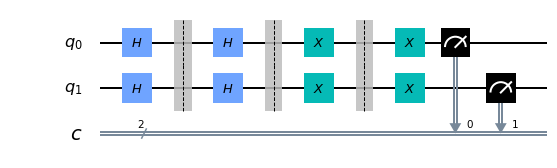

In [19]:
circ = QuantumCircuit(2,2)
circ.h(0)
circ.barrier(0)
circ.h(0)
circ.barrier(0)
circ.x(0)
circ.barrier(0)
circ.x(0)

circ.h(1)
circ.barrier(1)
circ.h(1)
circ.barrier(1)
circ.x(1)
circ.barrier(1)
circ.x(1)

circ.measure(0, 0)
circ.measure(1, 1)
circ.draw(output = 'mpl')

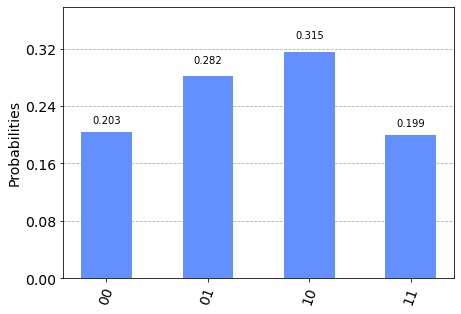

In [128]:
from qiskit.tools.visualization import plot_histogram

job = execute(circ, backend = simulator, shots = 1024)
counts = job.result().get_counts()
plot_histogram(counts)


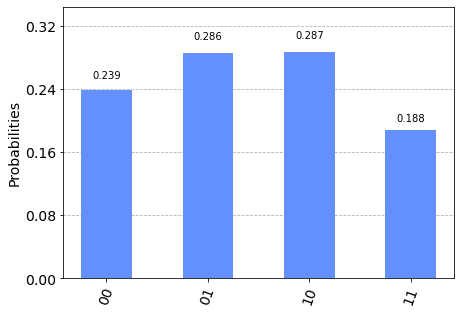

In [129]:
# machine= provider.get_backend('ibmq_london')
# noise_model = NoiseModel.from_backend(machine)

job = execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
counts = job.result().get_counts()
plot_histogram(counts)

## Amplification Functions

In [130]:
def one_qubit_readout_error_matrix(qubit_n, scale = 1):
    """
    Input: which qubit on the london device, scale (for noise scaling)
    Generates the readout error matrix
    
    organized as 
    
    P(0|0)  P(0|1)
    P(1|0)  P(1|1)
    
    """
    if (qubit_n == 0): 
        errors = [0.013333333333333334, 0.050000000000000044]
    elif (qubit_n == 1): 
        errors = [0.013333333333333334, 0.05666666666666664]
    x, y = errors
    x = scale*x
    y = scale*y
    
    matrix = [[1-x, y], [x, 1-y]]
    
    return matrix

def column_sum_to_1(matrix): 
    """
    Makes sure that columns of a 2x2 matrix sum to 1
    """
    matrix = np.transpose(matrix)
    
    for r in range(len(matrix)):
        summ = 0
        for c in range(len(matrix[r])):
            summ += matrix[r][c]
        for c in range(len(matrix[r])): 
            matrix[r][c] = (matrix[r][c])/summ
            
    matrix = np.transpose(matrix)
    return matrix
        

def two_qubit_readout_error_matrix(mat_1, mat_2):
    """
    Input: corresponding readout error matrices of the 2 qubits
    Output: their kronecker product
    """
    P = mat_1
    Q = mat_2
    
    matrix = column_sum_to_1(np.kron(P,Q))
    return matrix

def get_2_qubit_readout_matrix_regular(scale): 
    """
    for amplifying readout errors
    """
    
    #what should happen after all
    P_scale =  one_qubit_readout_error_matrix(0, scale)
    Q_scale = one_qubit_readout_error_matrix(1, scale)
    R_scale = two_qubit_readout_error_matrix(P_scale, Q_scale)
    
    return R_scale

def get_2_qubit_readout_matrix_after_readout_measurement(scale): 
    """
    for amplifying readout errors
    """
    #what already happened
    P_1 = one_qubit_readout_error_matrix(0)
    Q_1 = one_qubit_readout_error_matrix(1)
    R_1 = two_qubit_readout_error_matrix(P_1, Q_1)
    
    #what should happen after all
    P_scale =  one_qubit_readout_error_matrix(0, scale)
    Q_scale = one_qubit_readout_error_matrix(1, scale)
    R_scale = two_qubit_readout_error_matrix(P_scale, Q_scale)
    
    #what then needs to happen 
    """
    XR_1 = R_scale
    X = R_scale*(R_1)^-1
    """
    inverse = np.linalg.inv(R_1)
    X = np.dot(R_scale, inverse)
    
    return X

def counts_to_array(counts): 
    """
    Turning counts (dict) to array format ...for matrix multiplication
    """
    array = [[counts['00']],[counts['01']], [counts['10']], [counts['10']] ]
    return array
def array_to_counts(array, shots = 1024):
    """
    Turning array into counts(dict)
    """
    #making sure the array has correct number of shots
    summ = 0
    for i in array: 
        summ+=i
    new_array = [(i/summ)*1024 for i in array]
    
    counts = {'00': float(new_array[0]), '01': float(new_array[1]), '10':float(new_array[2]), '11': float(new_array[3])}
    
    return counts

def counts_after_readout_amp(counts, scale):
    """
    Input: Counts, amplification factor
    Output: modified counts
    """
    array = counts_to_array(counts)
    matrix = get_2_qubit_readout_matrix_after_readout_measurement(scale)
    new_array = np.dot(matrix, array)
    
    return array_to_counts(new_array)
    

In [131]:
# import random

# def amping_readout_errors(counts, prob_matrix, scale): 
#     """
#     Returning counts with amped up errors
#     """
#     #print(scale)
#     new_counts={'00':0, '01':0, '10': 0, '11':0}
    
#     for key in counts.keys(): 
#         index = 0
#         if (key == '00'): 
#             index = 0
#         elif(key == '01'): 
#             index = 1
#         elif(key == '10'): 
#             index = 2
#         else:
#             index = 3
            
#         #print(index)
#         #scaling the probabilties
#         prob_matrix_diff = np.copy(prob_matrix)
#         prob = prob_matrix_diff[index]
#         old_prob = np.copy(prob)
        
#         print('old prob is ')
#         print(prob)
#         amends = 0
#         for i in range(len(prob)): 
#             real_scale = scale -1
#             if (i!= index): 
#                 amends += real_scale*prob[i]
#                 prob[i] = scale*prob[i]
#         prob[index] -= amends
        
#         new_prob = np.copy(prob)
        
#         print('new_prob is ')
#         print(new_prob)
        
#         actual_prob = [ float((new_prob[i])/(old_prob[i])) for i in range(len(prob))]
       
        
#         summ = 0
#         for i in actual_prob:
#             summ+=i
#         actual_prob = [i/summ for i in actual_prob]
        
        
#         prob =np.copy(actual_prob)
#         print('actual prob is ')
#         print(prob)
       
        
#         #print(prob)
#         #for flipping counts 
#         a = prob[0]
#         b = a+ prob[1]
#         c = b+ prob[2]
        
#         #iterating over all the counts in that key and randomly flipping
#         for i in range(counts[key]):
#             p = (random.randint(1, 10001))/10000

#             if (p<a): 
#                 new_counts['00'] = new_counts['00']+1
#             elif (p>a and p<b): 
#                 new_counts['01'] +=1
#             elif (p>b and p<c): 
#                 new_counts['10'] +=1
#             else:
#                 new_counts['11'] +=1
#     #print('Initial Counts: ')
#     #print(counts)
#     #print('final counts: ')
#     #print(new_counts)
#     return new_counts
        

In [132]:
# counts = {'00':100, '01':0, '10': 0, '11':0}
# amping_readout_errors(counts, prob_matrix = probabilities, scale = 2)

In [133]:
# def mean_counts(counts): 
#     """
#     Return the mean counts
#     """
#     keys = ['00', '01', '10', '11']
#     mean_counts={'00':0, '01':0, '10': 0, '11':0}
    
#     for key in keys:
#         results = []
#         for count in counts:
#             results.append(count[key])
#         mean_counts[key] = np.mean(results)
#     return mean_counts

# modified_counts = []
# true_counts = []
# count = {'00': 100, '01': 0, '10': 0, '11': 0}
# scaly = 7

# for i in range(1000): 
#     #true count
#     true_counts.append(amping_readout_errors(count, prob_matrix = probabilities, scale = scaly+1))
#     #modified counts 
#     new_count = amping_readout_errors(counts, prob_matrix = probabilities, scale = 2)
#     modified_counts.append(amping_readout_errors(count, prob_matrix = probabilities, scale = scaly))
# print('True count is ')
# print(mean_counts(true_counts))
# print('Modiefied count is ')
# print(mean_counts(modified_counts))

        

In [134]:
# probabilities

## VQE Optimized Circuit 

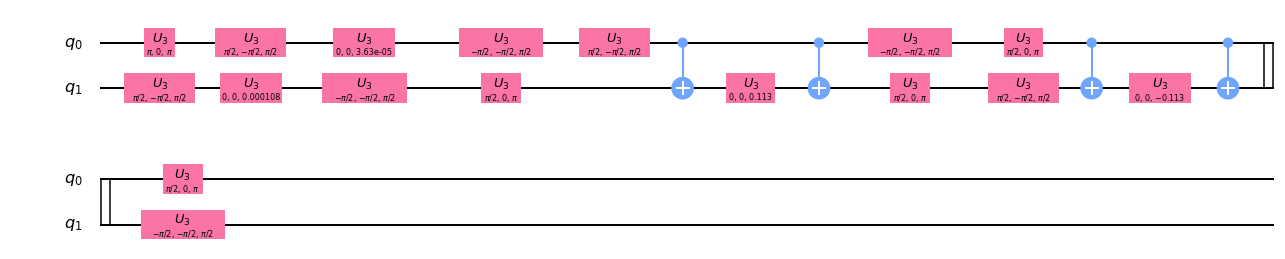

In [49]:
string = """OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\nu3(pi,0,pi) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(0,0,3.6279236e-05) q[0];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,-pi/2,pi/2) q[1];\nu3(0,0,0.00010816593) q[1];\nu3(-pi/2,-pi/2,pi/2) q[1];\nu3(pi/2,0,pi) q[1];\ncx q[0],q[1];\nu3(0,0,0.11268152) q[1];\ncx q[0],q[1];\nu3(-pi/2,-pi/2,pi/2) q[0];\nu3(pi/2,0,pi) q[0];\nu3(pi/2,0,pi) q[1];\nu3(pi/2,-pi/2,pi/2) q[1];\ncx q[0],q[1];\nu3(0,0,-0.11268152) q[1];\ncx q[0],q[1];\nu3(pi/2,0,pi) q[0];\nu3(-pi/2,-pi/2,pi/2) q[1];\n"""
vqe_circ = QuantumCircuit.from_qasm_str(string)
# vqe_circ.measure(0,0)
# vqe_circ.measure(1,1)
vqe_circ.draw(output = 'mpl')

## Hammyfication of Circuits

In [50]:
from qiskit import ClassicalRegister
import math

Hamiltonian = """II
IZ 
ZI
ZZ
XX"""

Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]


circuits = []
for line in iter(Hamiltonian.splitlines()):
    circ = vqe_circ.copy()
    for index in range(len(line)):
        op = line[index]
        
        ##do nothing if Z or I
        if(op == "X"): 
            #hadamard in u3
            circ.u3(math.pi/2, 0, math.pi, index)
        elif(op == "Y"):
            circ.rx(pi/2, index)
    c = ClassicalRegister(2)
    circ.add_register(c)
    circ.measure([0], [0])
    circ.measure([1],[1])
    circuits.append(circ)

In [51]:
# because first 4 circuits are really the same thing (II, IZ, ZZ, ZI does not require any addition of gates for measurements)
less_circuits = [circuits[0], circuits[4]]

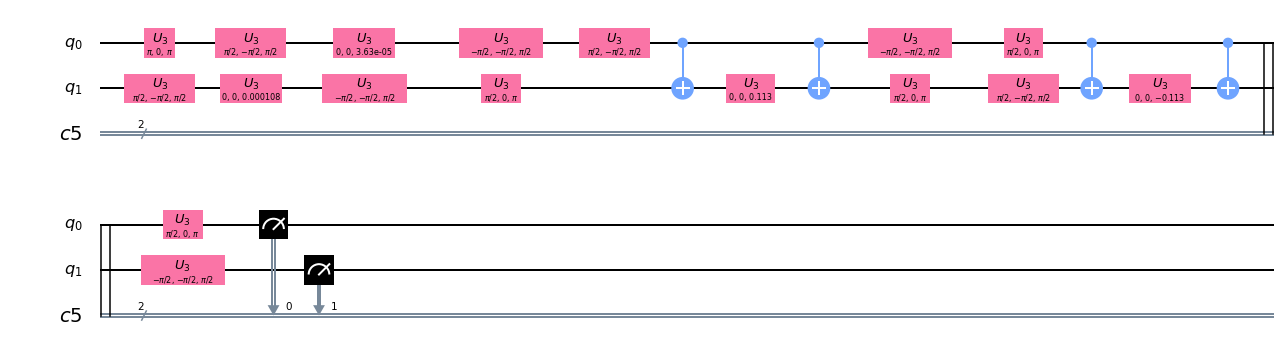

In [52]:
less_circuits[0].draw(output = 'mpl')

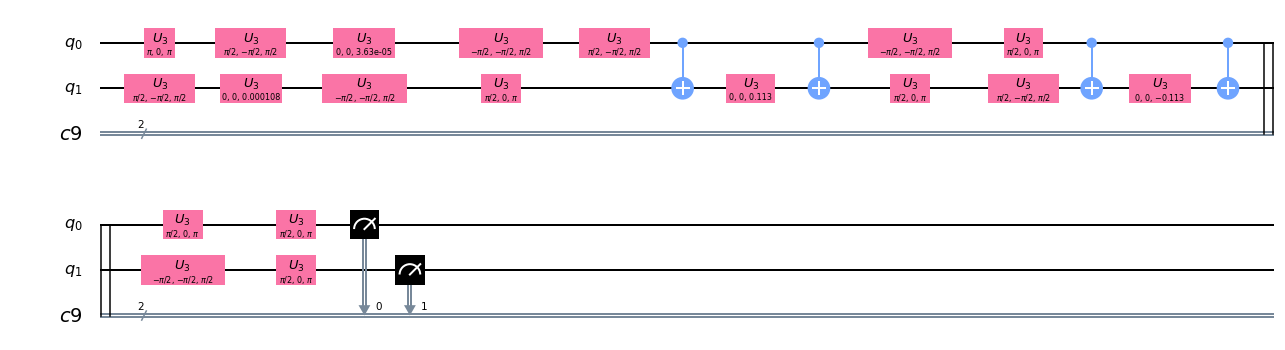

In [53]:
less_circuits[1].draw(output = 'mpl')

## Functions for computing Expectation value

In [54]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

In [55]:
def get_expec_val_H2(results, h, shots = 1024):
    keys = results.keys()
    e_val = 0
    for key in keys:
        counts =int(results[key])
        
        key_val = int(key)
        key_dval = int(binaryToDecimal(key_val))
        
        ## II
        if (h==0):
            e_val += (int(counts)/shots)
        ## IZ
        elif (h==1):
            if (key_dval == 1 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
         ## ZI
        elif (h==2):
            if (key_dval == 2 or key_dval==3):
                e_val += (-1)*(int(counts)/shots)
            else: 
                e_val += (int(counts)/shots)
        ## ZZ and XX(measured in ZZ basis)
        elif(h==3 or h==4):
            # 00 and 11 are +1 eigenvalues and others are -1
            if (key_dval == 0 or key_dval == 3):
                e_val += (int(counts)/shots)
            else:
                e_val += (-1)*(int(counts)/shots)
    return e_val
    

# Running the circuit on all 19 noise models (Ideal simulator, 18 noisy simulators)

In [56]:
from qiskit import Aer
simulator = Aer.get_backend('qasm_simulator')

In [57]:
probabilities = np.array([[9.7706e-01, 3.5280e-02, 1.9940e-02, 7.2000e-04],
       [2.9400e-03, 9.4472e-01, 6.0000e-05, 1.9280e-02],
       [4.9850e-02, 1.8000e-03, 9.4715e-01, 3.4200e-02],
       [1.5000e-04, 4.8200e-02, 2.8500e-03, 9.1580e-01]])

### Function to evaluate circuits

In [135]:
def evaluator(circuits, noise_model = None, 
              weights =  [-1.053, 0.395, -0.395, -0.011, 0.181], readout_amp = False, scale = 1, probabilities = probabilities):
    """
    Input: circuits, noise model to run on , weights of the local hammys
    Output: expectation value (energy)
    
    """
    
    #Running the circuits 
    results = []
    for circ in circuits: 
        job =  execute(circ, backend = simulator, noise_model = noise_model, shots = 1024)
        result = job.result().get_counts()
        results.append(result)
        
    #Amping up readout errors
    if (readout_amp): 
        for i in range(len(results)): 
            #print(probabilities)
            results[i] = counts_after_readout_amp(results[i], scale)
    
    #Converting counts to expec values of local hammys
    
    n = 5 #if 5 hammys, then length is 5, 5th one is assumed to be XX
    hammyfied_vals = []
    for i in range(n): 
        if (i <4):
            c = 0
        else: 
            c= 1
        hammyfied_val = get_expec_val_H2(results[c], i)
        hammyfied_vals.append(hammyfied_val)
    
    #Combining expectation values of local hamiltonians with the weights and adding nuclear repulsion energy
    
    shift = 0.7151043390810812
    expec_val = 0 + shift
    for i in range(len(hammyfied_vals)): 
        expec_val += weights[i]*hammyfied_vals[i]
        
    return expec_val
    

In [136]:
from qiskit import Aer
simulator = Aer.get_backend('qasm_simulator')

In [154]:
n_samples = 1000

ideal_mean = 0
idea_err = 0
pure_means = []
impure_means = []
impure_amped_up_means = []
pure_errs = []
impure_errs = []
impure_amped_up_errs = []

#Running Pure first
print('Running Pure first')

for nm in range(len(noise_models_pure)): 
    noise_model = noise_models_pure[nm]
    results = []
    for i in range(n_samples): 
#         # for tracking results 
#         if (i%25 == 0): 
#             print('---------'+str(i) + ' samples done--------------')
        result = evaluator(less_circuits, noise_model, readout_amp = False)
        results.append(result)
    mean = np.mean(results)
    err = np.std(results)/np.sqrt(len(results))
    pure_means.append(mean)
    pure_errs.append(err)
    print('---------'+str(nm) + ' models done--------------')





#Running impure next
print('Running imPure next')

for nm in range(len(noise_models_impure)): 
    noise_model = noise_models_impure[nm]
    results = []
    for i in range(n_samples): 
#         # for tracking results 
#         if (i%25 == 0): 
#             print('---------'+str(i) + ' samples done--------------')
        result = evaluator(less_circuits, noise_model, readout_amp = False)
        results.append(result)
    mean = np.mean(results)
    err = np.std(results)/np.sqrt(len(results))
    impure_means.append(mean)
    impure_errs.append(err)
    print('---------'+str(nm) + ' models done--------------')

#impure amped up next

print('Running ImPure amped up next')
for nm in range(len(noise_models_impure)): 
    
    noise_model = noise_models_impure[nm]
    results = []
    for i in range(n_samples): 
#         # for tracking results 
#         if (i%25 == 0): 
#             print('---------'+str(i) + ' samples done--------------')
        result = evaluator(less_circuits, noise_model, readout_amp = True, scale = 1+0.5*nm)
        results.append(result)
    mean = np.mean(results)
    err = np.std(results)/np.sqrt(len(results))
    impure_amped_up_means.append(mean)
    impure_amped_up_errs.append(err)
    print('---------'+str(nm) + ' models done--------------')

print('Running Ideal last')
#ideal sim last
results = []
for i in range(n_samples): 
#     # for tracking results 
#     if (i%25 == 0): 
#         print('---------'+str(i) + ' samples done--------------')
    result = evaluator(less_circuits)
    results.append(result)
ideal_mean = np.mean(results)
ideal_err = np.std(results)/np.sqrt(len(results))

        


Running Pure first
---------0 models done--------------
---------1 models done--------------
---------2 models done--------------
---------3 models done--------------
---------4 models done--------------
---------5 models done--------------
---------6 models done--------------
---------7 models done--------------
---------8 models done--------------
Running imPure next
---------0 models done--------------
---------1 models done--------------
---------2 models done--------------
---------3 models done--------------
---------4 models done--------------
---------5 models done--------------
---------6 models done--------------
---------7 models done--------------
---------8 models done--------------
Running ImPure amped up next
---------0 models done--------------
---------1 models done--------------
---------2 models done--------------
---------3 models done--------------
---------4 models done--------------
---------5 models done--------------
---------6 models done--------------
-------

## Plotting Results

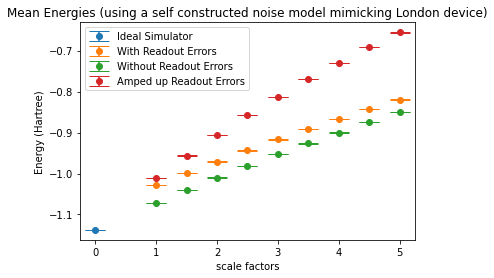

In [155]:
import matplotlib.pyplot as plt

f = plt.figure()
plt.errorbar(0, ideal_mean, yerr=ideal_err,capsize = 10, fmt ='o', label = 'Ideal Simulator' )
plt.errorbar(scales, impure_means, yerr=impure_errs,capsize = 10, fmt ='o', label = 'With Readout Errors' )
plt.errorbar(scales, pure_means, yerr=pure_errs,capsize = 10, fmt ='o', label = 'Without Readout Errors' )
plt.errorbar(scales, impure_amped_up_means, yerr=impure_amped_up_errs,capsize = 10, fmt ='o', label = 'Amped up Readout Errors' )

plt.title('Mean Energies (using a self constructed noise model mimicking London device)')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()
#f.savefig('1000sample.png', dpi = 1000)

In [156]:
ideal_mean

-1.137485000762669

In [157]:
probabilities

array([[9.7706e-01, 3.5280e-02, 1.9940e-02, 7.2000e-04],
       [2.9400e-03, 9.4472e-01, 6.0000e-05, 1.9280e-02],
       [4.9850e-02, 1.8000e-03, 9.4715e-01, 3.4200e-02],
       [1.5000e-04, 4.8200e-02, 2.8500e-03, 9.1580e-01]])

In [158]:
impure_amped_up_means

[-1.0101840036923562,
 -0.9564099304501688,
 -0.9060162449032937,
 -0.8571439656064188,
 -0.8130098044736062,
 -0.7694399304501688,
 -0.7300837068173562,
 -0.6905297214657937,
 -0.6555136745907937]

In [159]:
pure_means

[-1.071166981231419,
 -1.0403556452939187,
 -1.0100335925595438,
 -0.9814013562314188,
 -0.9527631042782939,
 -0.9263509734189188,
 -0.8999710242001688,
 -0.8742249617001688,
 -0.8496203406064187]

In [160]:
impure_means

[-1.0286093406064187,
 -0.9983868269345438,
 -0.9706992097470438,
 -0.9436980867001686,
 -0.9166173933407938,
 -0.8911625691220438,
 -0.8665130730282937,
 -0.8419977273251689,
 -0.8193213542782937]

In [161]:
impure_errs

[0.00038838569473055774,
 0.0004260650679968631,
 0.00045310497171317934,
 0.0004607077952744371,
 0.000474136682292616,
 0.0005102958099620471,
 0.0005222121863429267,
 0.0005247253824866314,
 0.0005500773548555014]

In [162]:
impure_amped_up_errs

[0.0004464004182074317,
 0.00046352043531634773,
 0.0004942513815123103,
 0.00048209020330542107,
 0.00048549846681860645,
 0.00047217020036048396,
 0.0004782942899649455,
 0.00046761792356445466,
 0.00045476908810153594]

In [163]:
pure_errs

[0.00036809335171906197,
 0.00039801473490528114,
 0.0004114413602045364,
 0.00044628919412839944,
 0.0004750634102020117,
 0.0004920693715338036,
 0.0005063181767975186,
 0.0005260845731531444,
 0.0005386440056238959]

In [164]:
ideal_err

0.00023865328390982658

In [165]:
ideal_mean

-1.137485000762669